In [2]:
# import libraries
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
import numpy as np
from keras import backend as K
%matplotlib inline

In [3]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

we plot a example of rectangle generating


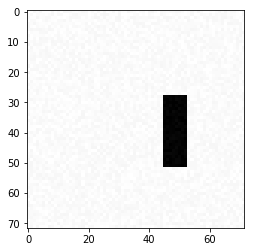

In [5]:
im = generate_a_rectangle(10, True)
print('we plot a example of rectangle generating')
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

we plot a example of disk generating


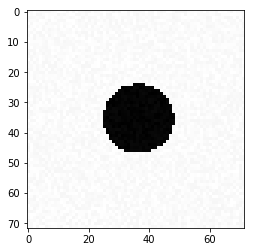

In [6]:
im = generate_a_disk(10)
print('we plot a example of disk generating')
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

we plot a example of triangle generating


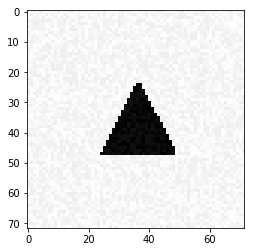

In [7]:
[im, v] = generate_a_triangle(20, False)
print('we plot a example of triangle generating')
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [52]:
def generate_dataset_denoising(nb_samples, amplitude_min_max=[20, 40],free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    noises = np.random.randint(*amplitude_min_max, size=nb_samples)
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            Y[i] = generate_a_rectangle(0.0, free_location)
        elif category == 1: 
            Y[i] = generate_a_disk(0.0, free_location)
        else:
            [Y[i], V] = generate_a_triangle(0.0, free_location)
        X[i] = Y[i] + noises[i] * np.random.random(Y[i].size)
        Y[i] /= 255
    return [X, Y]
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]


In [9]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    for i in range(nb_samples):
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


## Simple Classification :

In [10]:
[X_train, Y_train] = generate_dataset_classification(300, 20) # generate data set 
Y_train = np_utils.to_categorical(Y_train) # convert output to binary

In [11]:
def lin_classifier (optim) :
    model = Sequential() # create model
    model.add(Dense(3, input_shape=(5184,))) # add layers 
    model.add(Activation('softmax')) # add softmax activationas
                                    # functions to have the output as probabilities
    model.compile(loss='categorical_crossentropy',
                  optimizer=optim, metrics=['accuracy']) # define the compiler
    return model

In [12]:
model_sgd = lin_classifier ('sgd')
model_sgd.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
300/300 [==============================] - 2s 6ms/step - loss: 6.8766 - acc: 0.3667
Epoch 2/10
300/300 [==============================] - 0s 98us/step - loss: 7.9362 - acc: 0.3700
Epoch 3/10
300/300 [==============================] - 0s 89us/step - loss: 6.2674 - acc: 0.5033
Epoch 4/10
300/300 [==============================] - 0s 93us/step - loss: 6.0840 - acc: 0.5300
Epoch 5/10
300/300 [==============================] - 0s 98us/step - loss: 5.2483 - acc: 0.6367
Epoch 6/10
300/300 [==============================] - 0s 96us/step - loss: 5.7144 - acc: 0.5800
Epoch 7/10
300/300 [==============================] - 0s 89us/step - loss: 5.3030 - acc: 0.6200
Epoch 8/10
300/300 [==============================] - 0s 90us/step - loss: 5.4013 - acc: 0.5900
Epoch 9/10
300/300 [==============================] - 0s 103us/step - loss: 5.1307 - acc: 0.6767
Epoch 10/10
300/300 [==============================] - 0s 88us/step - loss: 5.1199 - acc: 0.6800


In [13]:
model_adam = lin_classifier ('Adam')
model_adam.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
300/300 [==============================] - 0s 773us/step - loss: 1.4247 - acc: 0.3967
Epoch 2/10
300/300 [==============================] - 0s 101us/step - loss: 0.6889 - acc: 0.7400
Epoch 3/10
300/300 [==============================] - 0s 99us/step - loss: 0.5030 - acc: 0.8033
Epoch 4/10
300/300 [==============================] - 0s 102us/step - loss: 0.3983 - acc: 0.8233
Epoch 5/10
300/300 [==============================] - 0s 100us/step - loss: 0.4882 - acc: 0.7767
Epoch 6/10
300/300 [==============================] - 0s 102us/step - loss: 0.3444 - acc: 0.8233
Epoch 7/10
300/300 [==============================] - 0s 106us/step - loss: 0.2647 - acc: 0.8933
Epoch 8/10
300/300 [==============================] - 0s 99us/step - loss: 0.2579 - acc: 0.8900
Epoch 9/10
300/300 [==============================] - 0s 105us/step - loss: 0.1924 - acc: 0.9700
Epoch 10/10
300/300 [==============================] - 0s 93us/step - loss: 0.1675 - acc: 0.9900


As expected the Adam optimizer converge very quickly compared to stochastic gradient descent optimizer

we test our model with input as a disk
the model predict a disk


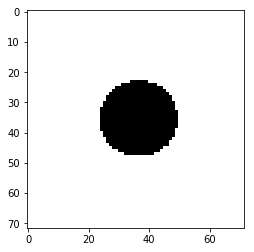

In [14]:
X_test = generate_a_disk()
print('we test our model with input as a disk')
X_test = X_test.reshape(1, X_test.shape[0])
pred = model_adam.predict(X_test)
if pred[0][0] == 1 :
    print('the model predict a rectangle')
elif pred[0][1] == 1 :
    print('the model predict a disk')
else :
    print('the model predict a triangle')
plt.imshow(X_test.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

## Visualization of the Solution :

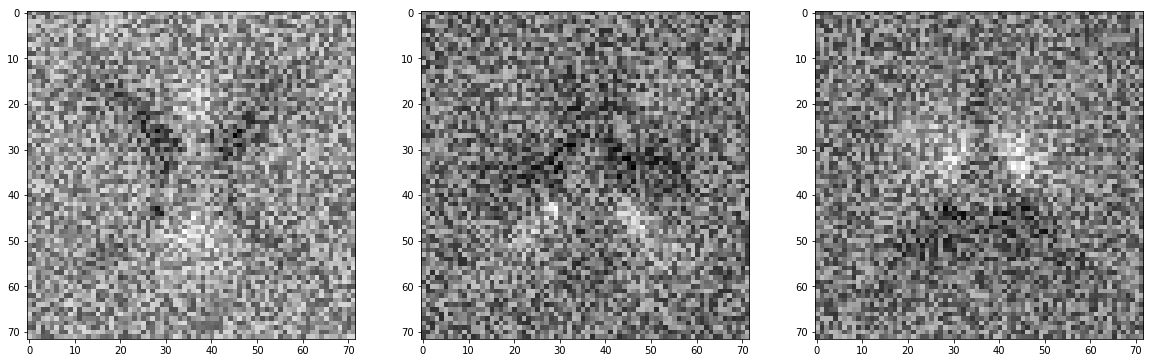

In [17]:
weights =model_adam.get_weights()[0]
fig, size = plt.subplots(figsize=(20,10),)
plt.subplot(131)
plt.imshow(weights.T[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(132)
plt.imshow(weights.T[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(133)
plt.imshow(weights.T[2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

the output of each layer is the inner product of the input image and the corresponding 
weights image, and the softmax of the output is maximum when both input and weights 
have the same gradient.
Then the neuron weights converge to the geometric shape which he should detected

## A More Difficult Classification Problem :

In [21]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y_train = np_utils.to_categorical(Y_train) 

In [22]:
[X_test, Y_test] = generate_test_set_classification()

In [23]:
model_adam = lin_classifier ('Adam')
model_adam.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
300/300 [==============================] - 0s 929us/step - loss: 2.7167 - acc: 0.3467
Epoch 2/10
300/300 [==============================] - 0s 101us/step - loss: 1.7299 - acc: 0.3867
Epoch 3/10
300/300 [==============================] - 0s 104us/step - loss: 1.1519 - acc: 0.4133
Epoch 4/10
300/300 [==============================] - 0s 106us/step - loss: 1.0003 - acc: 0.4900
Epoch 5/10
300/300 [==============================] - 0s 142us/step - loss: 1.0215 - acc: 0.5433
Epoch 6/10
300/300 [==============================] - 0s 79us/step - loss: 1.1324 - acc: 0.5167
Epoch 7/10
300/300 [==============================] - 0s 96us/step - loss: 0.9819 - acc: 0.5533
Epoch 8/10
300/300 [==============================] - 0s 105us/step - loss: 0.8670 - acc: 0.6067
Epoch 9/10
300/300 [==============================] - 0s 100us/step - loss: 0.8043 - acc: 0.6167
Epoch 10/10
300/300 [==============================] - 0s 88us/step - loss: 0.8006 - acc: 0.6533


In [24]:
model_adam.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 285us/step


[0.9406652450561523, 0.5133333337306977]

## CNN :

In [25]:
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
X_train = X_train.astype('float32')
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)
X_test = X_test.astype('float32')

(300, 72, 72, 1)


In [26]:
model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(72, 72, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=32, epochs=30, verbose=1)

Epoch 1/30
300/300 [==============================] - 1s 4ms/step - loss: 1.5221 - acc: 0.3767
Epoch 2/30
300/300 [==============================] - 1s 2ms/step - loss: 1.0860 - acc: 0.4167
Epoch 3/30
300/300 [==============================] - 1s 3ms/step - loss: 0.9457 - acc: 0.5300
Epoch 4/30
300/300 [==============================] - 1s 2ms/step - loss: 0.8042 - acc: 0.6767
Epoch 5/30
300/300 [==============================] - 1s 2ms/step - loss: 0.7116 - acc: 0.8000
Epoch 6/30
300/300 [==============================] - 1s 3ms/step - loss: 0.6704 - acc: 0.7467
Epoch 7/30
300/300 [==============================] - 1s 3ms/step - loss: 0.6541 - acc: 0.7200
Epoch 8/30
300/300 [==============================] - 1s 3ms/step - loss: 0.5787 - acc: 0.8000
Epoch 9/30
300/300 [==============================] - 1s 3ms/step - loss: 0.5266 - acc: 0.8800
Epoch 10/30
300/300 [==============================] - 1s 2ms/step - loss: 0.4940 - acc: 0.8733
Epoch 11/30
300/300 [============================

In [27]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 2ms/step


[0.902688680489858, 0.6399999992052714]

convolutional deep network outperform the dense network, we can see the 
convolutional deep network as two network in serial, the first part of preprocessing 
(convolutional) center the image, the second part (Dense) classify the image centered as 
in the previous part.

## A Regression Problem :

In [28]:
[X_train, Y_train] = generate_dataset_regression(3300, 20)
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
X_train = X_train.astype('float32')

We will sort the vertices by indexes to provide a unique output for triangle, and standaraized the output. 

In [29]:
def sort_vertices(output):
    outputreshaped = output.reshape(-1, 3, 2)
    outputcopied = outputreshaped.copy()
    sortedindexes = np.argsort(output[:, ::2], axis=1)
    for i, j in enumerate(sortedindexes):
        outputcopied[i, :] = outputcopied[i,j]
    return outputcopied.reshape(-1, 6)

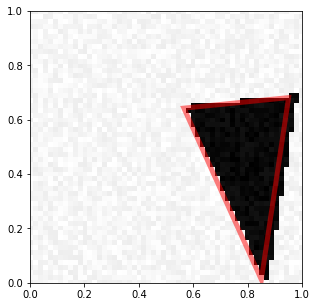

In [30]:
visualize_prediction(X_train[0], Y_train[0])

In [31]:
[X_test, Y_test] = generate_test_set_regression()
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)
X_test = X_test.astype('float32')
Y_sorted = sort_vertices(Y_test)

In [32]:
model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(72, 72, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2000, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6))
model.compile(loss='mean_squared_error', optimizer='adam')
Y_trainsorted = sort_vertices(Y_train)
model.fit(X_train, Y_trainsorted, batch_size=128, epochs=10, verbose=1, 
          validation_split=0.1)

Train on 2970 samples, validate on 330 samples
Epoch 1/10
2970/2970 [==============================] - 15s 5ms/step - loss: 0.0722 - val_loss: 0.0390
Epoch 2/10
2970/2970 [==============================] - 13s 4ms/step - loss: 0.0342 - val_loss: 0.0243
Epoch 3/10
2970/2970 [==============================] - 13s 4ms/step - loss: 0.0248 - val_loss: 0.0196
Epoch 4/10
2970/2970 [==============================] - 13s 4ms/step - loss: 0.0183 - val_loss: 0.0134
Epoch 5/10
2970/2970 [==============================] - 14s 5ms/step - loss: 0.0139 - val_loss: 0.0108
Epoch 6/10
2970/2970 [==============================] - 13s 5ms/step - loss: 0.0114 - val_loss: 0.0085
Epoch 7/10
2970/2970 [==============================] - 13s 5ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 8/10
2970/2970 [==============================] - 13s 4ms/step - loss: 0.0081 - val_loss: 0.0076
Epoch 9/10
2970/2970 [==============================] - 13s 4ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 10/10
2970/2970 [===

In [33]:
model.evaluate(X_test, Y_sorted)

300/300 [==============================] - 1s 2ms/step


0.007372343999644121

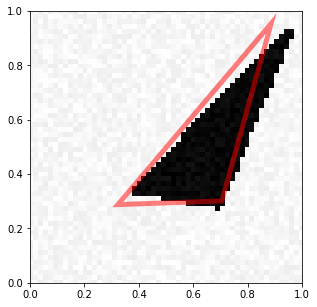

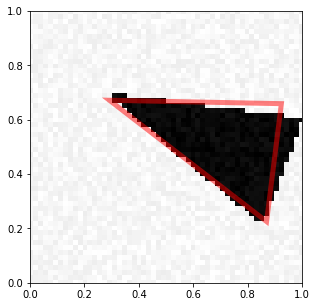

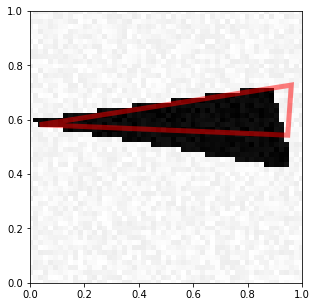

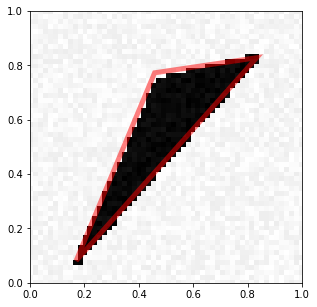

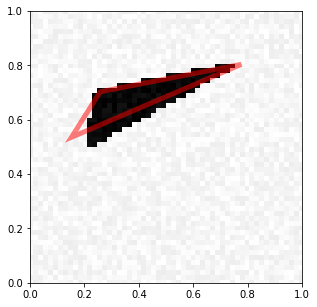

In [34]:
pred = model.predict(X_test)
visualize_prediction(X_test[0], pred[0])
visualize_prediction(X_test[10], pred[10])
visualize_prediction(X_test[30], pred[30])
visualize_prediction(X_test[100], pred[100])
visualize_prediction(X_test[230], pred[230])

## Image Denoising :

In [59]:
[X_train, Y_train] = generate_dataset_denoising(3000, [20, 40], True)

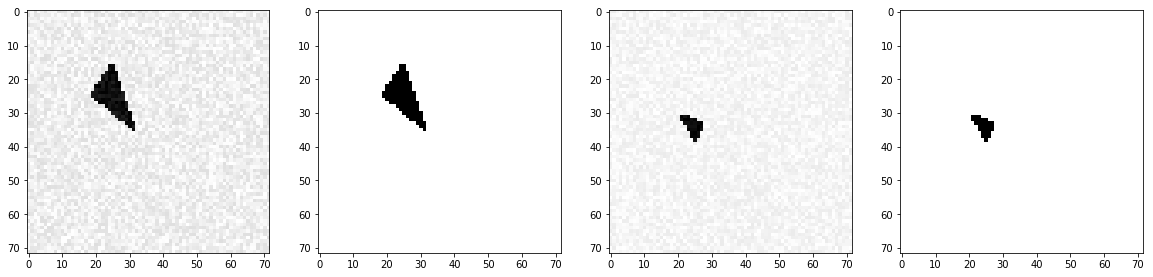

In [60]:
fig, size = plt.subplots(figsize=(20,10),)
plt.subplot(141)
plt.imshow(X_train[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(142)
plt.imshow(Y_train[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(143)
plt.imshow(X_train[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(144)
plt.imshow(Y_train[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [61]:
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
Y_train = Y_train.reshape(X_train.shape[0], 72, 72, 1)

In [62]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(72, 72, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D(size = (2,2)))
model.add(Conv2D(16, (3, 3), activation='sigmoid', padding='same'))
model.add(UpSampling2D(size = (2,2)))
model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, batch_size=128, epochs=30, verbose=1, validation_split=0.1)

Train on 2700 samples, validate on 300 samples
Epoch 1/30
2700/2700 [==============================] - 26s 10ms/step - loss: 0.0743 - val_loss: 0.0224
Epoch 2/30
2700/2700 [==============================] - 24s 9ms/step - loss: 0.0155 - val_loss: 0.0108
Epoch 3/30
2700/2700 [==============================] - 24s 9ms/step - loss: 0.0093 - val_loss: 0.0079
Epoch 4/30
2700/2700 [==============================] - 24s 9ms/step - loss: 0.0071 - val_loss: 0.0062
Epoch 5/30
2700/2700 [==============================] - 24s 9ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 6/30
2700/2700 [==============================] - 24s 9ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 7/30
2700/2700 [==============================] - 23s 9ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 8/30
2700/2700 [==============================] - 23s 8ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 9/30
2700/2700 [==============================] - 24s 9ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 10/30
2700/2700 [==

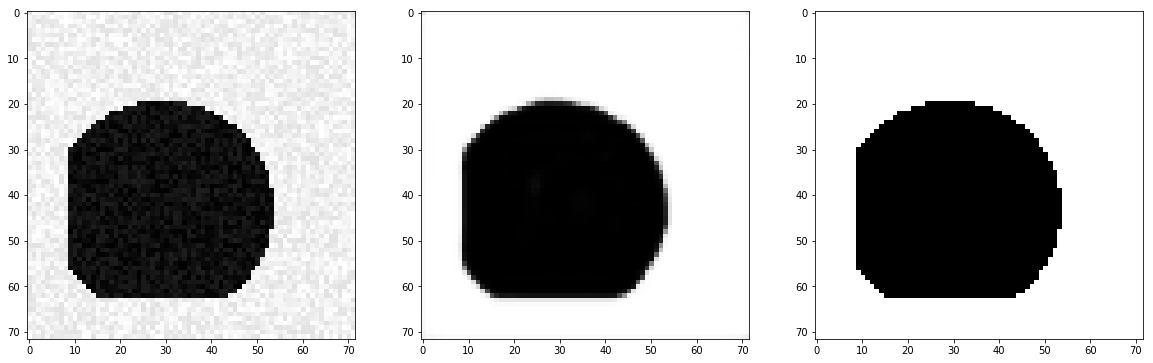

In [78]:
fig, size = plt.subplots(figsize=(20,10),)
plt.subplot(131)
plt.imshow(X_train[70].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(132)
plt.imshow(model.predict(X_train[70].reshape(1, 72, 72, 1)).reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(133)
plt.imshow(Y_train[70].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

the network denoise very well the image input but the edges are blurry. This is partly 
the high level of denoise which is a softening filter and the screen rendering. You will 
see that the white areas change as you alter zoom level.
If we increase the detail slider in the denoise filter the edges become more solid.